In [25]:
import sys
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

import scipy



pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )

def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_span_raw",
                "span inverso pb": "backward_digit_span_raw",
                "reloj": "clock_drawing_test",
                'TMT A (papel) Z': 'tmt_a_z',
                'TMT B (papel) Z': 'tmt_b_z',
                'Digit - symbol Z': 'digit_symbol_z',
                'Span directo Z': 'forward_digit_span_z',
                'Span inverso z': 'backward_digit_span_z'
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary

    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df['digit_symbol_z'] = df['digit_symbol_z'].replace('pendiente', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [26]:
# my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
# 2025-05-26_12-12-40
my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-26_12-12-40/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'
# eye_movements_path = '/home/gus/repos/tmt-analysis/src/eye_analysis/eye_movement_dataset.csv'
eye_movements_path = '/home/gus/repos/tmt-analysis/src/eye_analysis/eye_movement_dataset_2025-06-02-16-06-1748891726.csv'

# data/hand_analysis/2025-05-30_20-39-12/analysis.csv
newest_file_path = '../data/hand_analysis/2025-05-30_20-39-12/analysis.csv'

df_hand = pd.read_csv(newest_file_path)

In [133]:
df_hand.head(50)

,subject_id,trial_id,trial_type,is_valid,trial_order_of_appearance,speed_threshold,non_cut_zigzag_amplitude,non_cut_total_distance,non_cut_rt,non_cut_mean_speed,non_cut_std_speed,non_cut_peak_speed,non_cut_mean_acceleration,non_cut_std_acceleration,non_cut_peak_acceleration,non_cut_mean_abs_acceleration,non_cut_std_abs_acceleration,non_cut_peak_abs_acceleration,non_cut_mean_negative_acceleration,non_cut_std_negative_acceleration,non_cut_peak_negative_acceleration,non_cut_hesitation_time,non_cut_travel_time,non_cut_search_time,non_cut_hesitation_distance,non_cut_travel_distance,non_cut_search_distance,non_cut_hesitation_avg_speed,non_cut_travel_avg_speed,non_cut_search_avg_speed,non_cut_state_transitions,non_cut_hesitation_ratio,non_cut_total_hesitations,non_cut_average_duration,non_cut_max_duration,non_cut_hesitation_periods,non_cut_correct_targets_touches,non_cut_wrong_targets_touches,non_cut_number_of_crosses,non_cut_distance_difference_from_ideal,non_cut_area_difference_from_ideal,non_cut_intra_target_time,non_cut_inter_target_time,zigzag_amplitude,total_distance,rt,mean_speed,std_speed,peak_speed,mean_acceleration,std_acceleration,peak_acceleration,mean_abs_acceleration,std_abs_acceleration,peak_abs_acceleration,mean_negative_acceleration,std_negative_acceleration,peak_negative_acceleration,hesitation_time,travel_time,search_time,hesitation_distance,travel_distance,search_distance,hesitation_avg_speed,travel_avg_speed,search_avg_speed,state_transitions,hesitation_ratio,total_hesitations,average_duration,max_duration,hesitation_periods,correct_targets_touches,wrong_targets_touches,number_of_crosses,distance_difference_from_ideal,area_difference_from_ideal,intra_target_time,inter_target_time,invalid_cause,sex,age,group
0,1,8,PART_A,True,2,0.249557,NaN,3.724429,18105.0,0.234523,0.396439,2.179282,0.047388,6.879797,35.943649,3.256482,6.060460,35.943649,-5.645628,5.059799,-24.032105,4.800709,3.819829,7.265095,0.219123,2.290905,1.214401,0.045635,0.601419,0.167429,29.0,0.556892,3.0,1.600236,4.333857,"[4.333857099999932, 0.2668112999999721, 0.2000...",14.0,0.0,NaN,0.018329,0.003361,1.132456,1.163709,NaN,1.949203,12.673535,0.186377,0.333672,1.618993,0.070504,5.374726,30.813423,2.437437,4.790778,30.813423,-5.200584,4.323734,-23.887010,4.600668,2.184420,3.667516,0.205492,1.135167,0.608545,0.044656,0.521840,0.165943,15.0,0.678056,2.0,2.300334,4.333857,"[4.333857099999932, 0.2668112999999721]",8.0,0.0,NaN,0.026317,0.004466,1.464958,0.197898,NaN,F,52,HC
1,1,7,PART_B,True,3,0.249557,-1.172266,3.451943,18091.0,0.207785,0.300602,1.611697,-0.061160,5.210043,32.119982,2.548640,4.544527,39.313705,-4.028169,4.778131,-39.313705,0.900082,5.035507,10.666591,0.142386,2.048972,1.260584,0.156133,0.406854,0.118207,30.0,0.151642,3.0,0.300027,0.766811,"[0.7668111000000408, 0.06664189999992232, 0.06...",14.0,0.0,NaN,0.035763,0.002531,1.192406,1.100900,-1.011120,1.628623,9.714532,0.197580,0.303137,1.611697,-0.106081,5.759827,32.119982,2.702608,5.087511,39.313705,-5.156251,6.412476,-39.313705,0.833453,2.166822,5.233447,0.126591,0.858814,0.643217,0.149678,0.396326,0.122924,16.0,0.277792,2.0,0.416726,0.766811,"[0.7668111000000408, 0.06664189999992232]",8.0,0.0,NaN,0.049065,0.001413,1.147711,0.199746,NaN,F,52,HC
2,1,11,PART_A,True,4,0.249557,NaN,3.498912,15807.0,0.246446,0.337667,1.740980,0.002754,5.915293,44.017661,3.007017,5.093972,44.017661,-4.005684,3.894316,-19.661114,0.567047,4.618742,8.999594,0.174643,2.205751,1.118519,0.307829,0.477812,0.124327,32.0,0.109346,4.0,0.141762,0.366989,"[0.3669890999999552, 0.06666559999985111, 0.10...",14.0,0.0,NaN,0.021340,0.002588,1.011571,1.034961,NaN,1.944105,8.480254,0.283062,0.383512,1.740980,-0.001122,6.760589,44.017661,3.253390,5.926299,44.017661,-4.332304,4.090317,-19.661114,0.433655,2.533195,3.899708,0.149260,1.292571,0.502274,0.343948,0.510063,0.128844,17.0,0.146167,2.0,0.216827,0.366989,"[0.3669890999999552, 0.06666559999985111]",8.0,0.0,NaN,0.016579,0.003162,0.952390,0.199828,NaN,F,52,HC
3,1,21,PART_B,True,5,0

In [27]:
df_hand['is_valid'].value_counts(dropna=False)

is_valid
True     1022
False     818
Name: count, dtype: int64

Index(['suj', 'group', 'clasificación de caso',
       'comentario (tipo de caso o criterio de exclusión)', 'id participante',
       'fecha', 'hora', 'neuropsicol.', 'eyetracker', 'sex', 'age', 'glasses',
       'observaciones', 'mmse', 'mmse fallas', 'tmt_a_raw', 'tmt_a_z',
       'tmt_b_raw', 'tmt b papel errores', 'tmt_b_z', 'digit_symbol_raw',
       'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
       'backward_digit_span_raw', 'backward_digit_span_z',
       'clock_drawing_test', 'years_of_education'],
      dtype='object')


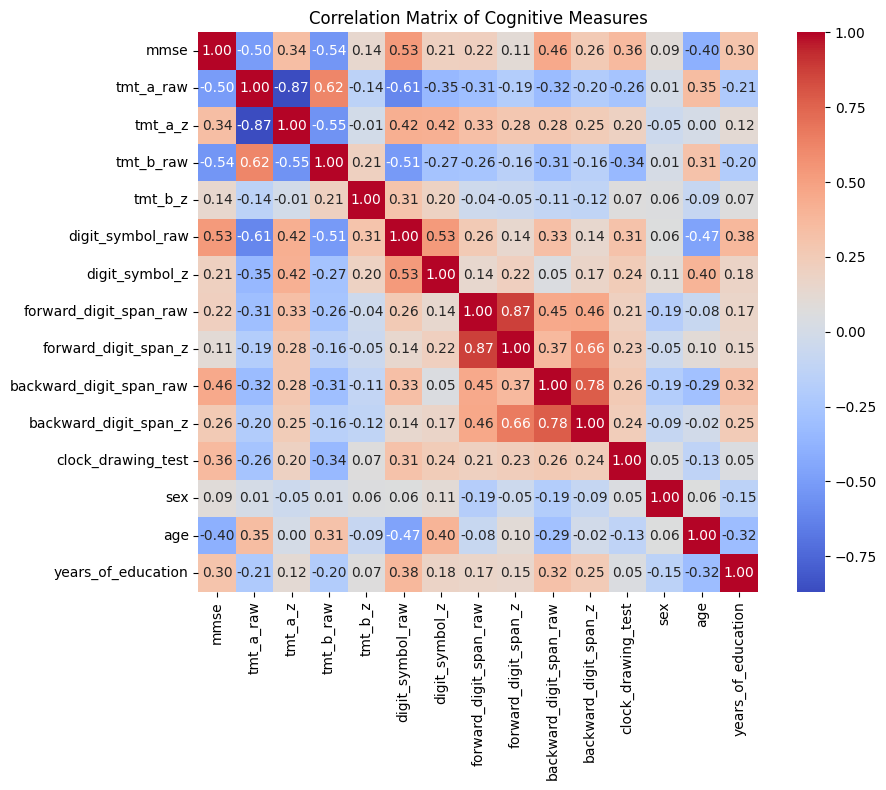

In [33]:
df_metadata = clean_metadata(metadata_path)

# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse','tmt_a_raw', 'tmt_a_z',
                    'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                    'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test',]

demographic_columns = ['sex', 'age','years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_columns + cognitive_columns].copy()

df_all = df_hand.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [34]:
min_age = 51
metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_columns:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")


print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=0.672
T-test: age, p=0.09681
T-test: years_of_education, p=0.23728
42
55


In [30]:
df_hand[df_hand['subject_id'] == 101]

,subject_id,trial_id,trial_type,is_valid,trial_order_of_appearance,speed_threshold,non_cut_zigzag_amplitude,non_cut_total_distance,non_cut_rt,non_cut_mean_speed,non_cut_std_speed,non_cut_peak_speed,non_cut_mean_acceleration,non_cut_std_acceleration,non_cut_peak_acceleration,non_cut_mean_abs_acceleration,non_cut_std_abs_acceleration,non_cut_peak_abs_acceleration,non_cut_mean_negative_acceleration,non_cut_std_negative_acceleration,non_cut_peak_negative_acceleration,non_cut_hesitation_time,non_cut_travel_time,non_cut_search_time,non_cut_hesitation_distance,non_cut_travel_distance,non_cut_search_distance,non_cut_hesitation_avg_speed,non_cut_travel_avg_speed,non_cut_search_avg_speed,non_cut_state_transitions,non_cut_hesitation_ratio,non_cut_total_hesitations,non_cut_average_duration,non_cut_max_duration,non_cut_hesitation_periods,non_cut_correct_targets_touches,non_cut_wrong_targets_touches,non_cut_number_of_crosses,non_cut_distance_difference_from_ideal,non_cut_area_difference_from_ideal,non_cut_intra_target_time,non_cut_inter_target_time,zigzag_amplitude,total_distance,rt,mean_speed,std_speed,peak_speed,mean_acceleration,std_acceleration,peak_acceleration,mean_abs_acceleration,std_abs_acceleration,peak_abs_acceleration,mean_negative_acceleration,std_negative_acceleration,peak_negative_acceleration,hesitation_time,travel_time,search_time,hesitation_distance,travel_distance,search_distance,hesitation_avg_speed,travel_avg_speed,search_avg_speed,state_transitions,hesitation_ratio,total_hesitations,average_duration,max_duration,hesitation_periods,correct_targets_touches,wrong_targets_touches,number_of_crosses,distance_difference_from_ideal,area_difference_from_ideal,intra_target_time,inter_target_time,invalid_cause,sex,age,group
1820,101,17,PART_A,True,2,0.134722,NaN,3.504167,20542.0,0.187467,0.205568,1.341763,-0.009477,3.755317,29.162549,2.317407,2.955016,29.162549,-3.000172,2.851922,-20.636780,1.635873,8.032686,9.033620,0.405783,1.987808,1.110576,0.247850,0.248472,0.122972,35.0,0.169195,5.0,0.327175,0.402346,"[0.36659340001642704, 0.20020000031217933, 0.3...",14.0,0.0,NaN,0.060232,0.002900,1.307681,1.702322,NaN,1.863601,11.804786,0.187051,0.209954,1.341763,-0.072946,3.661364,14.431110,2.296292,2.852710,20.636780,-2.991664,2.935168,-20.636780,1.233528,4.032800,4.700312,0.315939,1.002031,0.545631,0.256432,0.248527,0.116087,20.0,0.234229,4.0,0.308382,0.366593,"[0.36659340001642704, 0.20020000031217933, 0.3...",8.0,0.0,NaN,0.087218,0.002432,1.395177,0.200403,NaN,F,71,HC
1821,101,11,PART_B,True,3,0.134722,-1.199979,4.428549,24032.0,0.203732,0.260837,2.085645,0.011863,5.506418,35.378449,2.868875,4.700036,35.378449,-3.661250,4.643778,-33.438046,3.233802,8.337508,10.164321,0.706244,2.520161,1.202144,0.218329,0.302037,0.118512,40.0,0.279467,7.0,0.461972,0.966610,"[0.4667232003994286, 0.23342389985919, 0.96660...",15.0,0.0,NaN,0.076619,0.006507,1.521740,0.431271,-0.944385,2.121247,10.458423,0.259769,0.308531,2.085645,-0.011688,6.123158,35.378449,3.240454,5.195446,35.378449,-3.928329,4.935900,-30.836464,0.700147,3.635487,3.830911,0.154066,1.346685,0.620497,0.219861,0.370027,0.162553,17.0,0.161487,2.0,0.350074,0.466723,"[0.4667232003994286, 0.23342389985919]",8.0,0.0,NaN,0.035424,0.004400,1.138414,0.197646,NaN,F,71,HC
1822,101,1,PART_A,True,4,0.134722,NaN,2.079999,25004.0,0.106903,0.236325,1.691077,0.025179,4.171747,26.037121,1.624682,3.842462,27.362242,-4.608470,5.245114,-27.362242,0.333437,3.072714,16.027143,0.056642,1.177106,0.846250,0.168302,0.382274,0.052956,18.0,0.097893,1.0,0.333437,0.333437,[0.33343710005283356],9.0,0.0,NaN,0.026604,0.002890,2.317494,0.893343,NaN,1.565843,23.538058,0.086946,0.226157,1.691077,0.032290,4.042762,26.037121,1.407912,3.789822,27.362242,-4.684082,5.679308,-27.362242,0.333437,2.272856,15.362515,0.056642,0.852485,0.656716,0.168302,0.374069,0.042829,15.0,0.127935,1.0,0.333437,0.333437,[0.33343710005283356],8.0,0.0,NaN,0.027133,0.002572,2.539044,0.195498,NaN,F,71,HC
1823,101,6,PART_B,False,5,0.134722,NaN,NaN,NaN,N

In [13]:
# min_age = 51
# min_number_of_trials_by_type = 1
# df = df_all.copy()
# print("df['subject_id'].nunique():", df['subject_id'].nunique())

# df_valid = df[df["is_valid"]]
# print("df_valid['subject_id'].nunique() [recorte por validos]:", df_valid['subject_id'].nunique())

# df_valid = df_valid[df_valid['age'] >= min_age]
# print("df_valid['subject_id'].nunique() [[recorte por edad]]:", df_valid['subject_id'].nunique())

# valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

# subjects_with_enough_valid_trials = valid_counts[
#     (valid_counts.get('PART_A', 0) >= min_number_of_trials_by_type) & (valid_counts.get('PART_B', 0) >= min_number_of_trials_by_type)
# ].index

# df_valid = df_valid[df_valid['subject_id'].isin(subjects_with_enough_valid_trials)]
# print("df_valid['subject_id'].nunique(): [recorte por cantidad de trials minimo]", df_valid['subject_id'].nunique())

# digital_tmt_vars = [
#        'rt','total_distance', 'non_cut_correct_targets_touches',
#        'wrong_targets_touches', 'mean_speed',
#        'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
#        'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
#        'peak_abs_acceleration', 'mean_negative_acceleration',
#        'std_negative_acceleration', 'peak_negative_acceleration',
#        'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
#        'travel_distance', 'search_distance', 'hesitation_avg_speed',
#        'travel_avg_speed', 'search_avg_speed', 'state_transitions',
#        'hesitation_ratio', 'total_hesitations', 'average_duration',
#        'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
#        'area_difference_from_ideal', 'intra_target_time', 'inter_target_time'
# ]

# non_digital_vars = ['mmse', 'tmt_a_raw','tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 
#                     'digit_symbol_raw', 'digit_symbol_z','forward_digit_span_raw', 
#                     'forward_digit_span_z', 'backward_digit_span_raw', 'backward_digit_span_z',
#                     'clock_drawing_test']


# df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

# df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]
# # Identify all PART_A and PART_B columns
# part_a_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_A')]
# part_b_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_B')]

# # Match variables by stripping suffixes
# common_vars = [col.replace('_PART_A', '') for col in part_a_cols if col.replace('_PART_A', '_PART_B') in part_b_cols]

# # Compute B/A ratios
# for var in common_vars:
#     a_col = f"{var}_PART_A"
#     b_col = f"{var}_PART_B"
#     ratio_col = f"{var}_B_A_ratio"
#     df_digital_tmt[ratio_col] = df_digital_tmt[b_col] / df_digital_tmt[a_col]

# # replace `inf` (it would be better to avoid it explicitly)
# df_digital_tmt = df_digital_tmt.replace([np.inf, -np.inf], np.nan)

# df_digital_tmt = df_digital_tmt.drop(['wrong_targets_touches_B_A_ratio'], axis=1)

# df_grouped = df_valid.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()
# # Pivot to have PART_A and PART_B sums in separate columns
# df_pivot = df_grouped.pivot(index='subject_id', columns='trial_type', values='is_valid').reset_index()
# df_pivot.columns = ['subject_id', 'is_valid_sum_A', 'is_valid_sum_B']
# df_digital_tmt = df_digital_tmt.merge(df_pivot, on='subject_id')
# df_digital_tmt['is_valid_sum_A'] = (df_digital_tmt['is_valid_sum_A'] / 10) * 100
# df_digital_tmt['is_valid_sum_B'] = (df_digital_tmt['is_valid_sum_B'] / 10) * 100


# print("len(df_digital_tmt):", len(df_digital_tmt))
# df_digital_tmt = df_digital_tmt.rename(columns={'subject_id':'suj'})


# df_digital_tmt_with_target = df_digital_tmt.merge(df_metadata_cognitive[['suj'] + ['group']], on='suj').set_index('suj')
# df_digital_tmt_with_target['group'] = (df_digital_tmt_with_target['group']
#                                        .str.replace('mci', '1').replace('control', '0')
#                                        .astype(int))


# dataset_big = list(df_digital_tmt_with_target.index)
# print(dataset_big)
# print("len(dataset_big):", len(dataset_big))

# demographic_df = df_metadata_cognitive[['suj', 'sex', 'age', 'years_of_education','group']].copy()
# demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
# demographic_df = demographic_df[demographic_df['suj'].isin(dataset_big)].set_index('suj')


# non_digital_df = df_metadata_cognitive[['suj'] + non_digital_vars + ['group']].copy()
# non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
# non_digital_df = non_digital_df[non_digital_df['suj'].isin(dataset_big)].set_index('suj')

# # Eye movements
# df_eye = pd.read_csv(eye_movements_path)
# cols =[col for col in df_eye.columns if col != 'group'] +  ['group'] 
# df_eye = df_eye[cols]
# df_eye['group'] = df_eye['group'].str.replace('MCI', '1').replace('control', '0').astype(int)
# df_eye = df_eye.drop(['new_rt_A', 'new_rt_B', 'PC_A', 'PC_B'], axis=1)


# df_digital_hand_and_eye = df_digital_tmt_with_target.merge(df_eye, on='suj').drop(['group_y'],axis=1).set_index('suj')
# df_digital_hand_and_eye['group'] = df_digital_hand_and_eye['group_x']
# df_digital_hand_and_eye = df_digital_hand_and_eye.drop('group_x',axis=1)


# # Check
# print(df_digital_tmt_with_target['group'].value_counts())
# print(demographic_df['group'].value_counts())
# print(non_digital_df['group'].value_counts())
# print(df_digital_hand_and_eye['group'].value_counts())

# only_part_b = False
# print("only_part_b:", only_part_b)

# if only_part_b:
#     df_digital_tmt_with_target = df_digital_tmt_with_target[[col for col in df_digital_tmt_with_target.columns if col.endswith(('B','b'))] + ['group']]
#     df_digital_hand_and_eye = df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if col.endswith(('B','b'))] + ['group']] 

In [116]:
# non_cut_cols = [col for col in df_all.columns if 'non_cut' in col]

# for col in non_cut_cols:
#     df_all[col].hist()
#     df_all[f'{col[8:]}'].hist()
#     plt.title(col)
#     plt.show()


<Axes: >

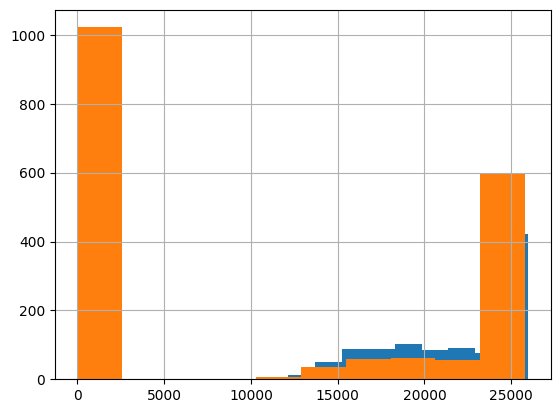

In [69]:
df_all['non_cut_rt'].hist()
df_all['rt'].hist()

In [146]:
# 1. Filter by validity, age, and minimum number of trials
min_age = 51
min_number_of_trials_by_type = 1
only_ratio = False
only_part_b = False

df = df_all.copy()
print("Initial unique subjects:", df['subject_id'].nunique())

df_valid = df[df["is_valid"]]
print("After filtering valid trials:", df_valid['subject_id'].nunique())

df_valid = df_valid[df_valid['age'] >= min_age]
print(f"After filtering by age >= {min_age}:", df_valid['subject_id'].nunique())

# Keep subjects with at least one valid PART_A and PART_B trial
valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

eligible_subjects = valid_counts[
    (valid_counts.get('PART_A', 0) >= min_number_of_trials_by_type) & 
    (valid_counts.get('PART_B', 0) >= min_number_of_trials_by_type)
].index

df_valid = df_valid[df_valid['subject_id'].isin(eligible_subjects)]
print("After filtering by min number of trials:", df_valid['subject_id'].nunique())

# 2. Pivot digital variables
digital_tmt_vars = [
       'rt','total_distance', 'non_cut_correct_targets_touches', 'non_cut_zigzag_amplitude', 'non_cut_rt', 
       'mean_speed', 'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions', 
       'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal', 'intra_target_time', 'inter_target_time'
]

df_digital_tmt = df_valid.pivot_table(
    index='subject_id',
    columns='trial_type',
    values=digital_tmt_vars
)

# Flatten column names (e.g., mean_speed_PART_A)
df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]

# 3. Compute B/A ratios
part_a_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_A')]
part_b_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_B')]
common_vars = [col.replace('_PART_A', '') for col in part_a_cols if f"{col.replace('_PART_A', '')}_PART_B" in part_b_cols]

for var in common_vars:
    df_digital_tmt[f"{var}_B_A_ratio"] = df_digital_tmt[f"{var}_PART_B"] / df_digital_tmt[f"{var}_PART_A"]

df_digital_tmt.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Add validity percentage
df_grouped = df_valid.groupby(['subject_id', 'trial_type'])['is_valid'].sum().unstack()
df_grouped.columns = ['is_valid_sum_A', 'is_valid_sum_B']
df_grouped['is_valid_sum_A'] = (df_grouped['is_valid_sum_A'] / 10) * 100
df_grouped['is_valid_sum_B'] = (df_grouped['is_valid_sum_B'] / 10) * 100

df_digital_tmt = df_digital_tmt.merge(df_grouped, left_index=True, right_index=True)

# 5. Merge with cognitive metadata
df_digital_tmt = df_digital_tmt.reset_index().rename(columns={'subject_id': 'suj'})
df_digital_tmt_with_target = df_digital_tmt.merge(
    df_metadata_cognitive[['suj', 'group']], on='suj', validate='one_to_one'
).set_index('suj')

df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)

# 6. Demographic data
dataset_big = df_digital_tmt_with_target.index.tolist()

demographic_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['suj'].isin(dataset_big),
    ['suj', 'sex', 'age', 'years_of_education', 'group']
].copy()

demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
demographic_df.set_index('suj', inplace=True)

# 7. Non-digital data
non_digital_vars = ['mmse', 'tmt_a_raw','tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 
                    'digit_symbol_raw', 'digit_symbol_z','forward_digit_span_raw', 
                    'forward_digit_span_z', 'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']

non_digital_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['suj'].isin(dataset_big),
    ['suj'] + non_digital_vars + ['group']
].copy()

non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df.set_index('suj', inplace=True)

# 8. Eye movement data
df_eye = pd.read_csv(eye_movements_path)
df_eye['group'] = df_eye['group'].str.replace('MCI', '1').replace('control', '0').astype(int)

df_digital_hand_and_eye = df_digital_tmt_with_target.reset_index().merge(
    df_eye, on='suj', validate='one_to_one', suffixes=('', '_eye')
).set_index('suj')

df_digital_hand_and_eye['group'] = df_digital_hand_and_eye['group']  # keep consistent naming
df_digital_hand_and_eye.drop(columns=['group_eye'], inplace=True, errors='ignore')
cols =[col for col in df_digital_hand_and_eye.columns if col != 'group'] +  ['group'] 
df_digital_hand_and_eye = df_digital_hand_and_eye[cols]

# 9. Optional: filter to only PART_B variables
if only_part_b:
    cols_b = [col for col in df_digital_tmt_with_target.columns if col.endswith(('B', 'b'))]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_b + ['group']]
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_b + ['group']]

if only_ratio:
    print("ONLY RATIO")
    cols_ratio = [i for i in df_digital_tmt_with_target.columns if '_ratio' in i]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_ratio + ['group']]
    print(df_digital_tmt_with_target.columns)
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_ratio + ['group']]



# Final checks
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())
print(df_digital_hand_and_eye['group'].value_counts())


Initial unique subjects: 92
After filtering valid trials: 86
After filtering by age >= 51: 84
After filtering by min number of trials: 79
group
1    42
0    37
Name: count, dtype: int64
group
1    42
0    37
Name: count, dtype: int64
group
1    42
0    37
Name: count, dtype: int64
group
1    30
0    26
Name: count, dtype: int64


In [79]:
df_all_nan = df_digital_tmt.loc[:, df_digital_tmt.isna().all()]
print("Columns with only NaN values:")
print(df_all_nan.columns.tolist())


Columns with only NaN values:
[]


In [82]:
from sklearn.feature_selection import VarianceThreshold


def detect_problematic_columns(df):
    all_nan = df.columns[df.isna().all()]
    constant = df.columns[df.nunique(dropna=False) <= 1]
    low_variance_selector = VarianceThreshold(threshold=0.01)
    low_variance_selector.fit(df.fillna(0))
    low_variance = df.columns[~low_variance_selector.get_support()]
    
    return {
        "all_nan": all_nan.tolist(),
        "constant": constant.tolist(),
        "low_variance": low_variance.tolist()
    }

# Example
problem_cols = detect_problematic_columns(df_digital_tmt)
print(problem_cols)


{'all_nan': [], 'constant': [], 'low_variance': ['area_difference_from_ideal_PART_A', 'area_difference_from_ideal_PART_B', 'distance_difference_from_ideal_PART_A', 'distance_difference_from_ideal_PART_B', 'hesitation_avg_speed_PART_A', 'hesitation_avg_speed_PART_B', 'inter_target_time_PART_A', 'inter_target_time_PART_B', 'mean_acceleration_PART_A', 'mean_acceleration_PART_B', 'mean_speed_PART_A', 'mean_speed_PART_B', 'search_avg_speed_PART_A', 'search_avg_speed_PART_B', 'search_distance_PART_A', 'search_distance_PART_B', 'std_speed_PART_A', 'std_speed_PART_B', 'travel_avg_speed_PART_A', 'travel_avg_speed_PART_B', 'inter_target_time_B_A_ratio', 'search_distance_B_A_ratio', 'state_transitions_B_A_ratio']}


In [97]:
set(problem_cols['low_variance'])

{'area_difference_from_ideal_PART_A',
 'area_difference_from_ideal_PART_B',
 'distance_difference_from_ideal_PART_A',
 'distance_difference_from_ideal_PART_B',
 'hesitation_avg_speed_PART_A',
 'hesitation_avg_speed_PART_B',
 'inter_target_time_B_A_ratio',
 'inter_target_time_PART_A',
 'inter_target_time_PART_B',
 'mean_acceleration_PART_A',
 'mean_acceleration_PART_B',
 'mean_speed_PART_A',
 'mean_speed_PART_B',
 'search_avg_speed_PART_A',
 'search_avg_speed_PART_B',
 'search_distance_B_A_ratio',
 'search_distance_PART_A',
 'search_distance_PART_B',
 'state_transitions_B_A_ratio',
 'std_speed_PART_A',
 'std_speed_PART_B',
 'travel_avg_speed_PART_A',
 'travel_avg_speed_PART_B'}

In [144]:
# df_digital_tmt_with_target = df_digital_tmt_with_target[list((set(df_digital_tmt.columns) - set(problem_cols['low_variance'] + ['suj']))) + ['group']]
# df_digital_tmt_with_target

In [53]:
len(df_digital_tmt_with_target.columns)

107

dataset: digital_test
n_splits: 4
Class distribution: {0: 37, 1: 42}
n_importances: 15

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔍 Feature importances for RandomForestClassifier (using permutation importance):
1. non_cut_correct_targets_touches_PART_B: 0.1980
2. is_valid_sum_A: 0.0720
3. is_valid_sum_B: 0.0495
4. non_cut_correct_targets_touches_PART_A: 0.0490
5. rt_PART_A: 0.0475
6. non_cut_zigzag_amplitude_PART_B: 0.0065
7. rt_PART_B: -0.0310
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


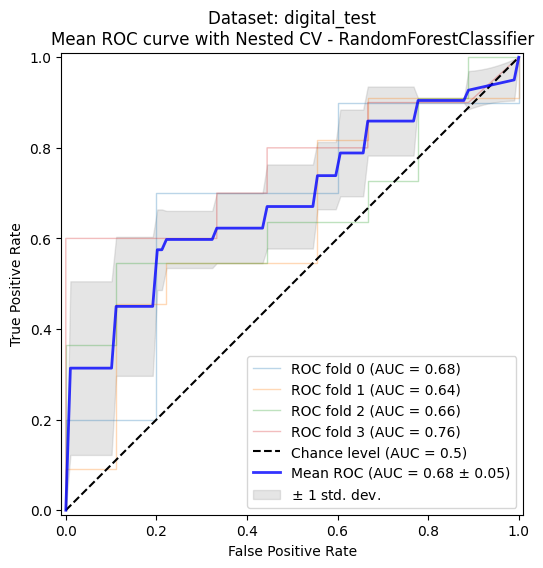

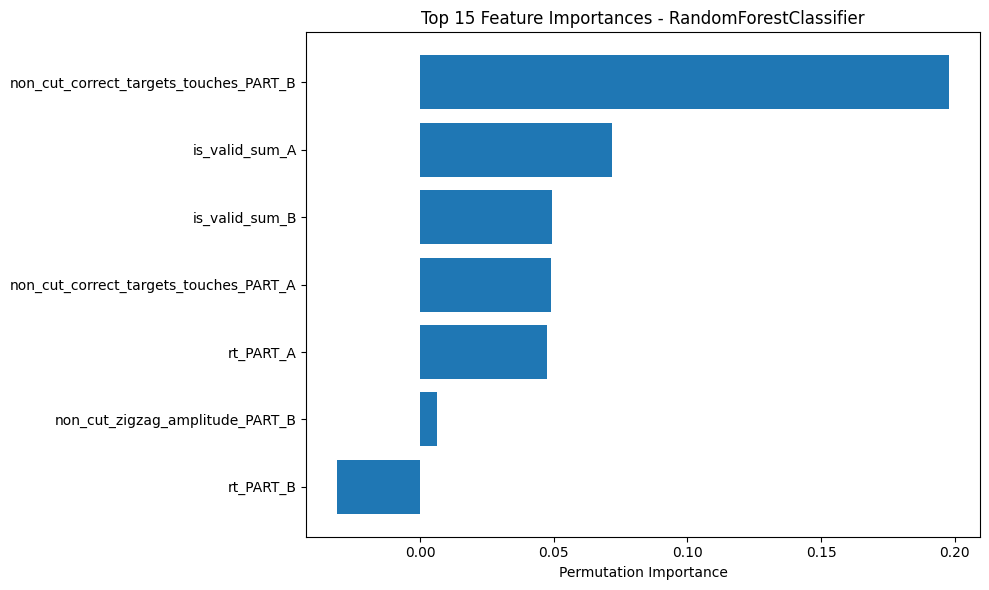

🔧 Best hyperparameters across folds for RandomForestClassifier:
  Fold 0: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
  Fold 2: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
  Fold 3: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
🔢 Global Confusion Matrix (all folds combined):
[[19 18]
 [14 28]]

🧪 Nested CV for: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits

🔍 Feature importances for SVC (using permutation importance):
1. non_cut_correct_targets_touches_PART_B: 0.2470
2. is_valid_sum_B: 0.1320
3. non_cut_correct_targets_touches_PART_A: 0.0320
4. non_cut_zigzag_amplitude_PART_B: 0.0120
5. rt_PART_A: 0.0040
6. is_valid_sum_A: 0.0020
7. rt_PART_B: -0.0430
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


<Figure size 600x500 with 0 Axes>

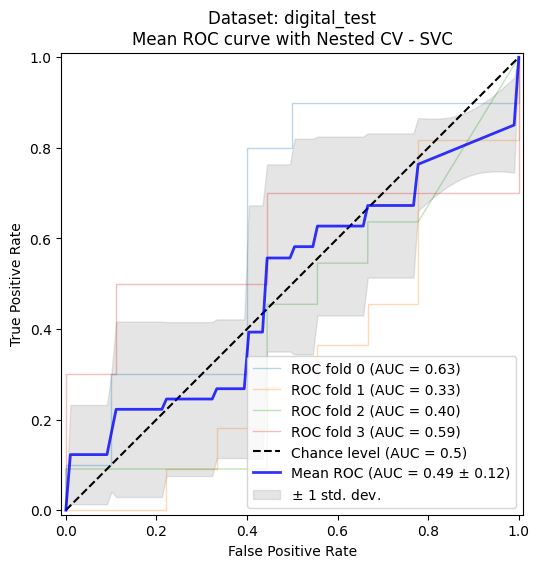

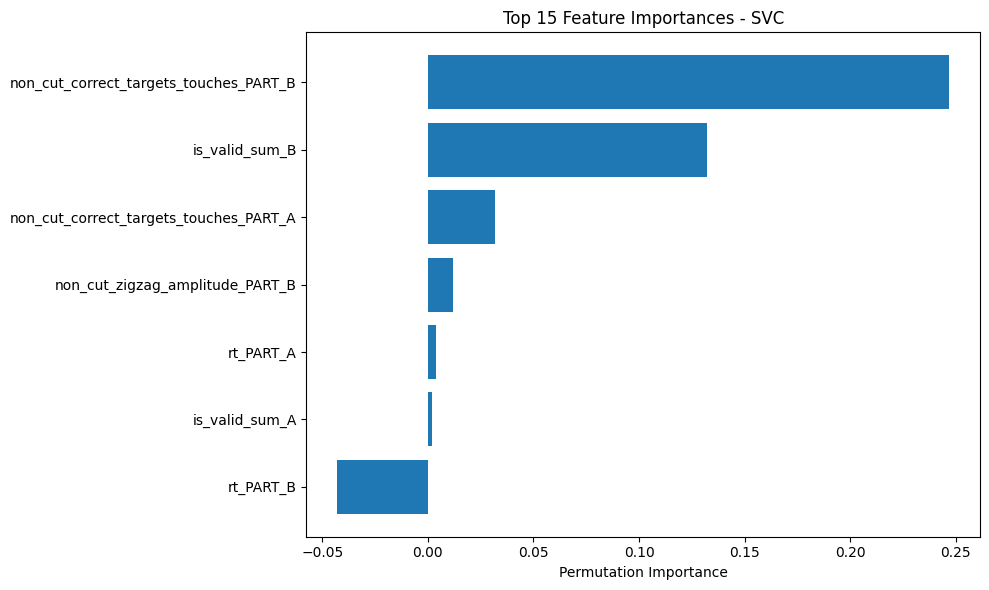

🔧 Best hyperparameters across folds for SVC:
  Fold 0: {'classifier__C': 10, 'classifier__kernel': 'linear'}
  Fold 1: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
  Fold 2: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
  Fold 3: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
🔢 Global Confusion Matrix (all folds combined):
[[11 26]
 [ 8 34]]

🧪 Nested CV for: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits

🔍 Feature importances for LogisticRegression (using permutation importance):
1. non_cut_correct_targets_touches_PART_B: 0.2450
2. is_valid_sum_B: 0.1070
3. rt_PART_A: 0.0350
4. non_cut_correct_targets_touches_PART_A: 0.0310
5. is_valid_sum_A: 0.0040
6. non_cut_zigzag_amplitude_PART_B: -0.0170
7. rt_PART_B: -0.0380
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


<Figure size 600x500 with 0 Axes>

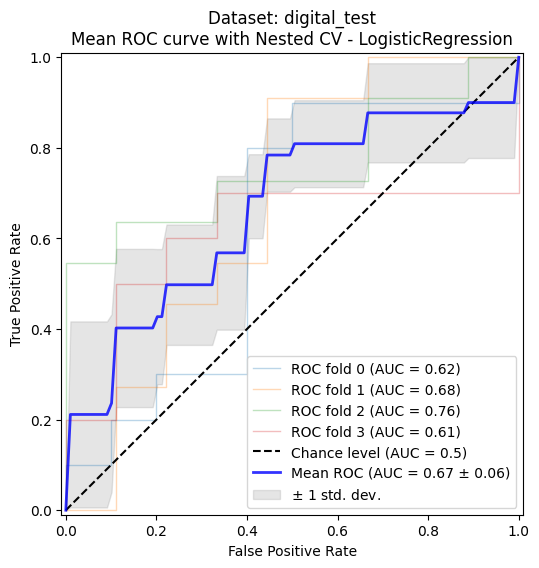

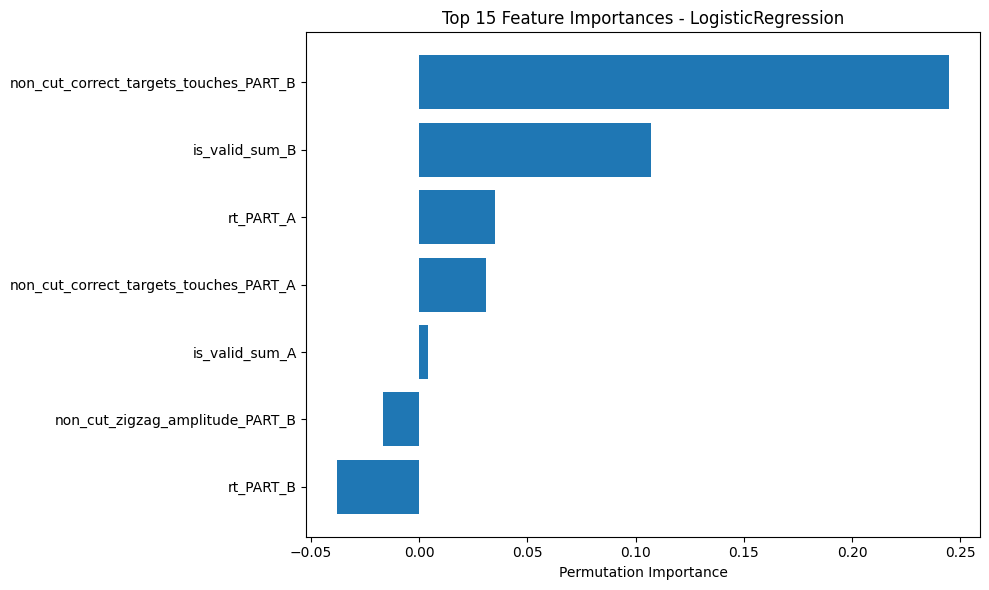

🔧 Best hyperparameters across folds for LogisticRegression:
  Fold 0: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 1: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 2: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
🔢 Global Confusion Matrix (all folds combined):
[[21 16]
 [12 30]]

🧪 Nested CV for: XGBClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits

🔍 Feature importances for XGBClassifier (using permutation importance):
1. non_cut_correct_targets_touches_PART_B: 0.0860
2. non_cut_correct_targets_touches_PART_A: 0.0715
3. is_valid_sum_B: 0.0045
4. is_valid_sum_A: 0.0045
5. rt_PART_A: -0.0780
6. rt_PART_B: -0.1480
7. non_cut_zigzag_amplitude_PART_B: -0.1600
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


<Figure size 600x500 with 0 Axes>

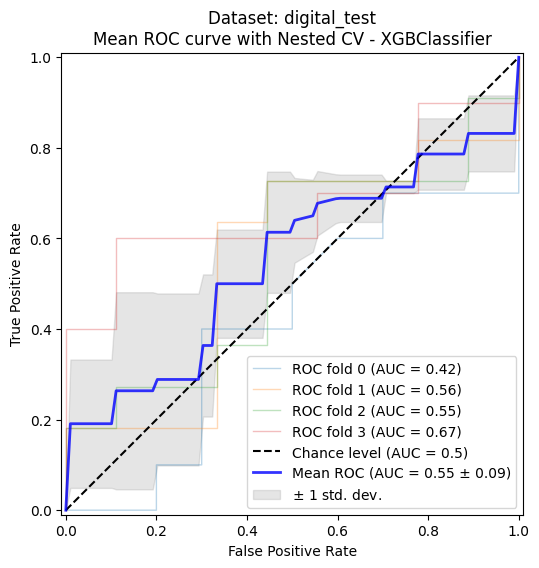

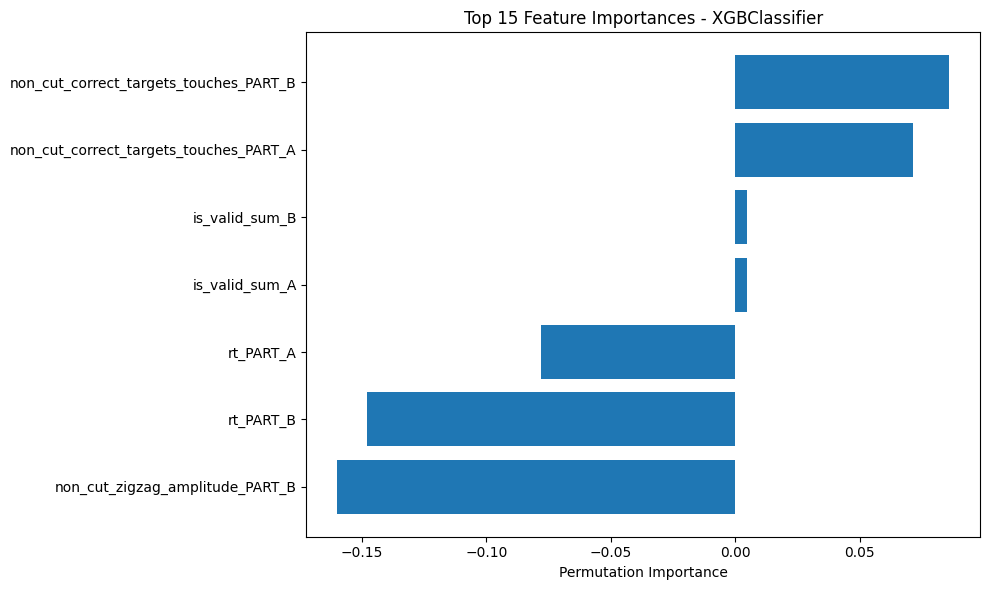

🔧 Best hyperparameters across folds for XGBClassifier:
  Fold 0: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
  Fold 1: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
  Fold 2: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
  Fold 3: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
🔢 Global Confusion Matrix (all folds combined):
[[17 20]
 [17 25]]

🏆 Model Performance Comparison:

ACCURACY:
  LogisticRegression: 0.645 ± 0.082
  RandomForestClassifier: 0.596 ± 0.063
  SVC: 0.570 ± 0.041
  XGBClassifier: 0.532 ± 0.039

BALANCED_ACCURACY:
  LogisticRegression: 0.638 ± 0.075
  RandomForestClassifier: 0.591 ± 0.066
  SVC: 0.544 ± 0.060
  XGBClassifier: 0.531 ± 0.034

PRECISION:
  LogisticRegression: 0.643 ± 0.067
  RandomForestClassifier: 0.622 ± 0.090
  SVC: 0.573 ± 0.042
  XGBClassifier: 0.561 

<Figure size 600x500 with 0 Axes>

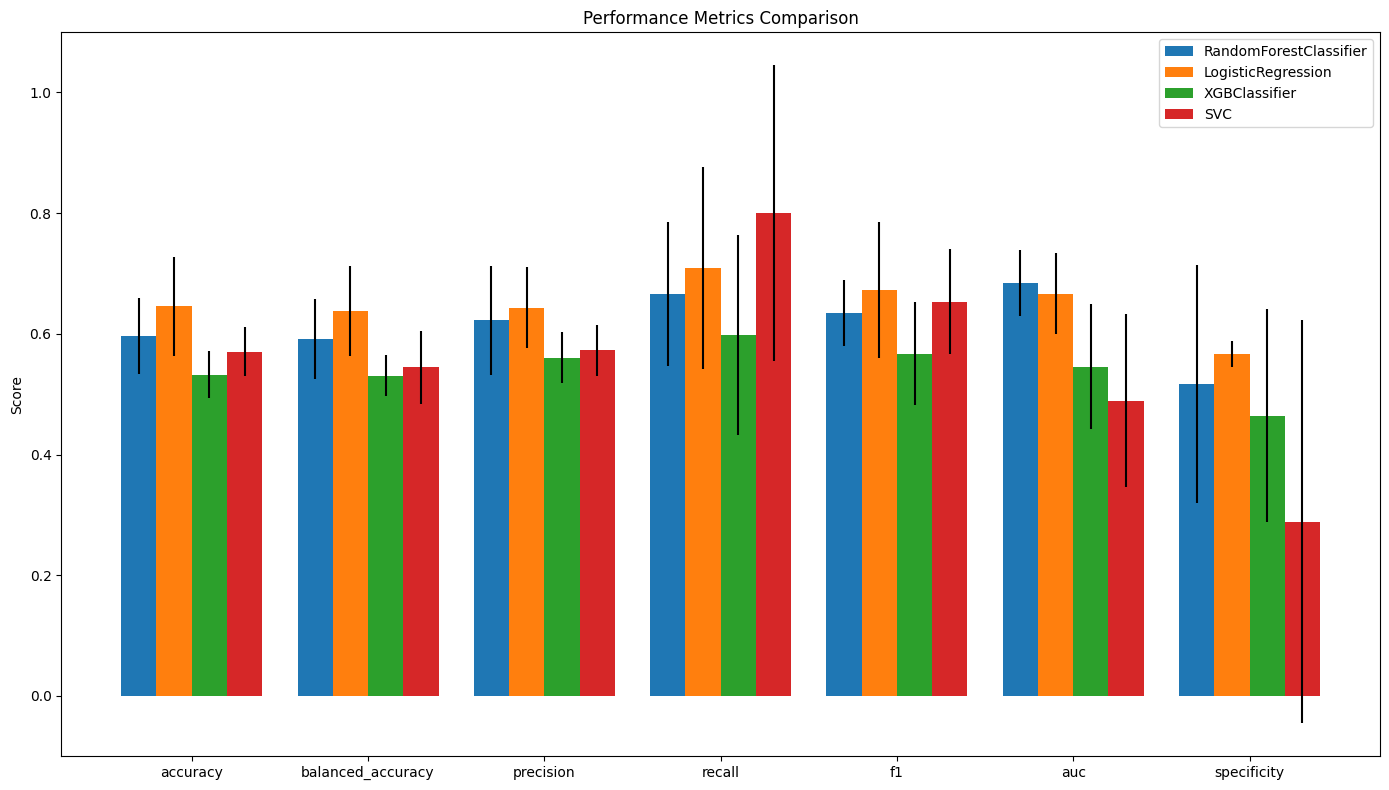

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.645 ± 0.08,0.638 ± 0.07,0.643 ± 0.07,0.709 ± 0.17,0.672 ± 0.11,0.666 ± 0.07,0.567 ± 0.02
RandomForestClassifier,0.596 ± 0.06,0.591 ± 0.07,0.622 ± 0.09,0.666 ± 0.12,0.635 ± 0.05,0.684 ± 0.05,0.517 ± 0.20
SVC,0.570 ± 0.04,0.544 ± 0.06,0.573 ± 0.04,0.800 ± 0.24,0.653 ± 0.09,0.489 ± 0.14,0.289 ± 0.33
XGBClassifier,0.532 ± 0.04,0.531 ± 0.03,0.561 ± 0.04,0.598 ± 0.17,0.567 ± 0.09,0.546 ± 0.10,0.464 ± 0.18


In [148]:
main_columns =  ['rt_PART_A','rt_PART_B', 'is_valid_sum_A', 'is_valid_sum_B', 
                 'non_cut_zigzag_amplitude_PART_B','non_cut_correct_targets_touches_PART_A', 
                 'non_cut_correct_targets_touches_PART_B', 'group']

df_digital_tmt_with_target = df_digital_tmt_with_target[main_columns]
dataset = 'digital_test'
print('dataset:', dataset)
n_splits = 4
print('n_splits:', n_splits)
n_importances = 15

# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        n_importances = 3
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': # less subjects
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case 'only_eye':
        X = df_eye.iloc[:, :-1].values
        y = df_eye.iloc[:, -1].values
        feature_names = df_eye.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye` o `digital_test_less_subjects`]')



# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
print("n_importances:", n_importances)

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],   
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=400)
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


# Perform nested CV for each model
for model in models:
    fig, ax = plt.subplots(figsize=(6, 6))
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    importances_added = False  # Prevents printing for every fold

    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    
    all_y_true = []
    all_y_pred = []

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            # ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
            #                          n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        # print("Best n_features_to_select:",
        #       grid.best_params_["feature_selection__n_features_to_select"])
    

        # Compute and plot feature importances for all models using permutation importance
        if not importances_added:
            print(f"\n🔍 Feature importances for {model_name} (using permutation importance):")

            # Permutation importance works with any fitted estimator
            result = permutation_importance(
                best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
            )
            sorted_idx = result.importances_mean.argsort()[::-1][:n_importances]
            top_feature_names = np.array(feature_names)[sorted_idx]
            top_importances = result.importances_mean[sorted_idx]

            # Print importances
            for i, (name, imp) in enumerate(zip(top_feature_names, top_importances), 1):
                print(f"{i}. {name}: {imp:.4f}")

            # Plot
            fig1, ax1 = plt.subplots(figsize=(10, 6))
            ax1.barh(range(len(top_importances)), top_importances[::-1], align='center')
            ax1.set_yticks(range(len(top_importances)), top_feature_names[::-1])
            ax1.set_xlabel("Permutation Importance")
            ax1.set_title(f"Top {n_importances} Feature Importances - {model_name}")
            plt.tight_layout()
            # plt.show()

            importances_added = True  # Only print once per model

      
        # # Track selected features
        # feature_selector = best_model.named_steps['feature_selection']
        # selected_mask = feature_selector.support_
        # fold_selected_features = feature_names[selected_mask]
        # selected_features.append(fold_selected_features)
        
        # # Update feature importance counts
        # for feature in fold_selected_features:
        #     feature_importance_counts[feature] += 1
        
        # Generate ROC curve
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        
        # Interpolate TPR for mean ROC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean ROC
    ax.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2, alpha=0.8)
    
    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")
    
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    # Print best params from each fold
    print(f"🔧 Best hyperparameters across folds for {model_name}:")
    for i, params in enumerate(best_params_list):
        print(f"  Fold {i}: {params}")
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
    # Plot confusion matrix (average across folds)
    plt.figure(figsize=(6, 5))
    cm_df = pd.DataFrame(fold_metrics)[['fold', 'model']].copy()
    cm_df['TP'] = 0
    cm_df['FP'] = 0
    cm_df['TN'] = 0
    cm_df['FN'] = 0
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_test = X[test_idx]
        y_test = y[test_idx]
        best_model = grid.best_estimator_  # Using the last trained model
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cm_df.loc[fold, ['TP', 'FP', 'TN', 'FN']] = [tp, fp, tn, fn]


    global_cm = confusion_matrix(all_y_true, all_y_pred)

    ## Optional: print the matrix
    print("🔢 Global Confusion Matrix (all folds combined):")
    print(global_cm)

# Compare metrics across models
print("\n🏆 Model Performance Comparison:")
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

# Print formatted comparison
for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
    print(f"\n{metric.upper()}:")
    for model_name in metrics_comparison.index:
        print(f"  {model_name}: {metrics_comparison.loc[model_name, metric]:.3f} ± "
              f"{metrics_std.loc[model_name, metric]:.3f}")

# Create a visual comparison of models across metrics
plt.figure(figsize=(14, 8))

metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
x = np.arange(len(metrics_to_plot))
width = 0.2
n_models = len(models)
offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

for i, model_name in enumerate(metrics_comparison.sort_values('auc', ascending=False).index):
    heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
    errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
    plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

plt.xticks(x, metrics_to_plot)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()


bold_max(metrics_comparison)
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)

In [150]:
df_digital_tmt_with_target = df_digital_tmt_with_target[main_columns]
df_digital_tmt_with_target

,rt_PART_A,rt_PART_B,is_valid_sum_A,is_valid_sum_B,non_cut_zigzag_amplitude_PART_B,non_cut_correct_targets_touches_PART_A,non_cut_correct_targets_touches_PART_B,group
suj,,,,,,,,
1,10.387079,10.488651,100.0,80.0,-1.285565,14.300000,13.750000,0
2,13.224333,16.590126,80.0,50.0,-2.227988,13.625000,10.600000,0
3,15.298076,15.611400,90.0,100.0,-1.990956,12.888889,11.500000,1
5,17.084629,16.168754,30.0,20.0,-1.541682,10.000000,9.500000,1
6,10.472231,11.572617,70.0,60.0,-1.673898,13.714286,13.166667,0
...,...,...,...,...,...,...,...,...
97,11.202620,15.843243,70.0,40.0,-1.909415,13.571429,12.000000,1
98,12.211602,14.504583,100.0,70.0,-1.535687,14.300000,10.857143,1
99,10.039310,14.269764,90.0,80.0,-1.773087,14.222222,13.250000,1


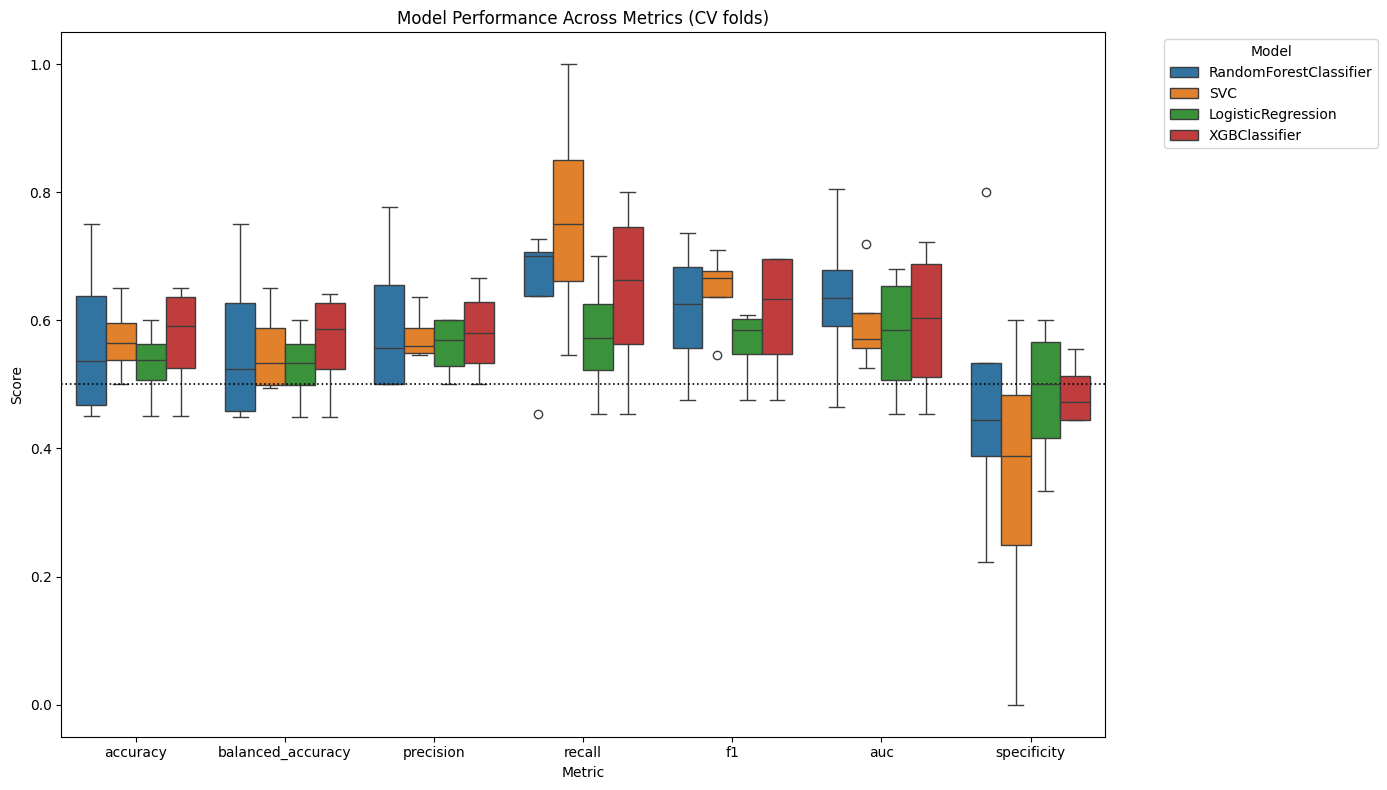

In [18]:
# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
dataset = 'digital_test'
importances_added = False
print('dataset:', dataset)
n_splits = 4
n_repeats = 10
global_seed = 42

# OJO CON ESTE CAMBIOOOO
df_digital_tmt_with_target = df_digital_tmt_with_target[main_columns]
df_digital_tmt_with_target

main_columns =  ['rt_PART_A','rt_PART_B', 'is_valid_sum_A', 'is_valid_sum_B', 
                 'non_cut_zigzag_amplitude_PART_B','non_cut_correct_targets_touches_PART_A', 
                 'non_cut_correct_targets_touches_PART_B', 'group']

# Selección del dataset
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': # less subjects
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye` o `digital_test_less_subjects`]')

# ───────────────────────────────────────────────────────────────
# 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
# ───────────────────────────────────────────────────────────────
n_importances = 15
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# ───────────────────────────────────────────────────────────────
# 2. Cross validation (Splits × Repeats)
# ───────────────────────────────────────────────────────────────

outer_cv = RepeatedStratifiedKFold(
    n_splits=n_splits,
    n_repeats=n_repeats,         
    random_state=global_seed # Global seed
)

mean_fpr = np.linspace(0, 1, 100)
all_metrics_df = pd.DataFrame(columns=[
    'model', 'repeat', 'fold',   
    'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])

# ───────────────────────────────────────────────────────────────
# 3. External loop (N iterations: n_splits folds × n_repeats )
# ───────────────────────────────────────────────────────────────
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested {n_splits}x{n_repeats} CV for: {model_name}")

    tprs, aucs, best_params_list, fold_metrics = [], [], [], []
    feature_importance_counts = {n: 0 for n in feature_names}

    # fig, ax = plt.subplots(figsize=(6, 6))
    all_y_true, all_y_pred = [], []

    # Enumeramos 'repeat' y 'fold' para guardar en métricas
    for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        repeat = outer_idx // n_splits
        fold = outer_idx % n_splits

        # ── Split
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
        seed = repeat  
        print('inner_cv seed:', seed)
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(LogisticRegression(max_iter=1000),
                                      n_features_to_select=n_importances)),
            ('classifier', model)
        ])

        # Hiperparámetros
        param_grid = param_grids.get(model_name, {})

        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=inner_cv,               
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        # ── Predicción
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        # ── Métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        fold_metrics.append({
            'model': model_name,
            'repeat': repeat,          
            'fold': fold,              
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        })

        # # ── ROC por fold
        # viz = RocCurveDisplay.from_predictions(
        #     y_test, y_pred_proba,
        #     name=f"R{repeat}-F{fold}", alpha=0.3, lw=1, ax=ax,
        #     plot_chance_level=False
        # )
        # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        # interp_tpr[0] = 0.0
        # tprs.append(interp_tpr)
        # aucs.append(viz.roc_auc)

    # ── Guardamos métricas
    all_metrics_df = pd.concat([all_metrics_df,
                                pd.DataFrame(fold_metrics)],
                               ignore_index=True)

    # ── ROC promedio (igual que antes) …
    # ── Confusion matrix global, plots, importancia de features, etc. …
    #      (sin cambios respecto a tu versión original)
    # …

# ───────────────────────────────────────────────────────────────
# 4. RESUMEN FINAL 
# ───────────────────────────────────────────────────────────────

metrics_comparison = (all_metrics_df
                      .groupby('model')
                      .mean(numeric_only=True))
metrics_std = (all_metrics_df
               .groupby('model')
               .std(numeric_only=True))

# save
dir = f'./results/modelling/{datetime.now().strftime("%Y-%m-%d-%H-%m-%s")}'
os.makedirs(dir, exist_ok=True)
all_metrics_df.to_csv(f'{dir}/all_metrics_{dataset}_nested{n_splits}x{n_repeats}.csv',index=False)

#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)


dataset: digital_test
Class distribution: {0: 37, 1: 42}

🧪 Nested 5x10 CV for: RandomForestClassifier
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 9
inner_cv seed: 9
inner_cv seed: 9
inner_cv seed: 9
inner_cv seed: 9

🧪 Nested 5x10 CV for: SVC
inner_cv seed: 0
inn

NameError: name 'metrics_to_plot' is not defined

In [19]:
metrics_comparison = (all_metrics_df
                      .groupby('model')
                      .mean(numeric_only=True))
metrics_std = (all_metrics_df
               .groupby('model')
               .std(numeric_only=True))


In [21]:
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)

NameError: name 'metrics_to_plot' is not defined

In [ ]:
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)

## Pruebas

In [ ]:
dataset = 'hand_and_eye'
n_importances = 15
plot_roc = False
plot_confusion_matrix = False
print('dataset:', dataset)
print("n_importances:", n_importances)


# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': 
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values 
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case 'eye_only':
        df_only_eye = df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col] + ['group']]
        X = df_only_eye.iloc[:, :-1].values
        y = df_only_eye.iloc[:, -1].values
        feature_names = df_only_eye.columns[:-1]
    case _:
        raise ValueError(
            'please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye`, `eye_only` or `digital_test_less_subjects`]'
            )

# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
print("n_importances:", n_importances)

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"],
    },
    "XGBClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    # xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=49) # LO CAMBIEEEEEEEEE!!!!!!!!!!!!!
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


# Perform nested CV for each model
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    importances_added = False  # Prevents printing for every fold

    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    
    all_y_true = []
    all_y_pred = []

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
                                     n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        # Compute and plot feature importances for all models using permutation importance
        if not importances_added:
            print(f"\n🔍 Feature importances for {model_name} (using permutation importance):")

            # Permutation importance works with any fitted estimator
            result = permutation_importance(
                best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
            )
            sorted_idx = result.importances_mean.argsort()[::-1][:n_importances]
            top_feature_names = np.array(feature_names)[sorted_idx]
            top_importances = result.importances_mean[sorted_idx]

            # Print importances
            for i, (name, imp) in enumerate(zip(top_feature_names, top_importances), 1):
                print(f"{i}. {name}: {imp:.4f}")

            # Plot
            fig1, ax1 = plt.subplots(figsize=(10, 6))
            ax1.barh(range(len(top_importances)), top_importances[::-1], align='center')
            ax1.set_yticks(range(len(top_importances)), top_feature_names[::-1])
            ax1.set_xlabel("Permutation Importance")
            ax1.set_title(f"Top {n_importances} Feature Importances - {model_name}")
            plt.tight_layout()
            # plt.show()

            importances_added = True  # Only print once per model
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
    
        if plot_roc:
            fig, ax = plt.subplots(figsize=(6, 6))
            # Generate ROC curve
            viz = RocCurveDisplay.from_estimator(
                best_model,
                X_test,
                y_test,
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
            )        
            
            # Interpolate TPR for mean ROC
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
    if plot_roc:
        # Calculate mean ROC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)       
        # Plot mean ROC
        ax.plot(mean_fpr, mean_tpr, color="b",
                label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
                lw=2, alpha=0.8)
        
        std_tpr = np.std(tprs, axis=0)
        ax.fill_between(mean_fpr,
                        np.maximum(mean_tpr - std_tpr, 0),
                        np.minimum(mean_tpr + std_tpr, 1),
                        color="grey", alpha=0.2,
                        label=r"$\pm$ 1 std. dev.")
        
        ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
            title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
        ax.legend(loc="lower right")
        plt.show()
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
# Compare metrics across models
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

bold_max(metrics_comparison_str, dataset=dataset)

In [ ]:
df_digital_hand_and_eye[list(df_digital_tmt_with_target.columns[:-1]) + ['number_of_sacc_A'] + ['group']]

In [ ]:
df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col] + ['group']]['number_of_sacc_A']

In [ ]:
df_hand_only =  df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index]
eye_cols = list(set(df_digital_hand_and_eye.columns) - set(df_hand_only.columns))
eye_cols

In [ ]:
eye_cols = [col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col]

In [ ]:
eye_cols = df_digital_hand_and_eye

selector = SelectKBest(score_func=f_classif, k=5)
X_eye_selected = selector.fit_transform(df_digital_hand_and_eye[eye_cols], df_digital_hand_and_eye['group'])
selected_names = np.array(eye_cols)[selector.get_support()]
print(selected_names)

In [ ]:
keeped_eye_cols = ['number_of_sacc_min_B', 'number_of_fix_A', 'number_of_fix_max_A',
                   'number_of_sacc_max_A', 'number_of_sacc_A']

hand_cols = [col for col in df_digital_hand_and_eye.columns if 'fix' not in col or 'sacc' not in col]
df_digital_hand_and_eye[keeped_eye_cols + hand_cols]